In [1]:
import numpy as np
import tensorflow as tf 
import sionna 
from sionna.rt import Scene, Transmitter, RadioMaterial, load_scene, PlanarArray, Receiver

import csv

2025-07-15 10:14:09.522469: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-15 10:14:09.522494: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-15 10:14:09.523127: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-15 10:14:09.527655: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-15 10:14:10.212104: W tensorflow/compiler/tf2

In [2]:
import os
os.chdir('/home/sionna/Documents/GitTest2/AP-Sionna-Testing')
print(f"Working directory: {os.getcwd()}")

scene = Scene("data/blender/2F_no_solid.xml")
scene.frequency = 2.4e9
print(f"Loaded scene with frequency: {scene.frequency} Hz")

Working directory: /home/sionna/Documents/GitTest2/AP-Sionna-Testing


2025-07-15 10:15:41.642900: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-07-15 10:15:41.646108: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-07-15 10:15:41.648398: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Loaded scene with frequency: 2400000000.0 Hz


In [3]:
scene.preview()

Renderer(camera=PerspectiveCamera(aspect=1.31, children=(DirectionalLight(intensity=0.25, position=(0.0, 0.0, …

In [4]:
# Add the tranmistters from the data positions file
def load_transmitters(filename):
    transmitters = []
    with open(filename, "r") as file:
        csv_reader = csv.reader(file)
        for row in csv_reader:
            name = row[0]
            x, y, z = map(float, row[1:])
            transmitters.append((name, [x, y, z])) 
    return transmitters

# Rotate and translate the AP Points 
Make the necessary transformations until they match the correct position

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [6]:
data = pd.read_csv('ap_data/2f.csv', header=None)
data.columns = ['Object', 'X', 'Y', 'Z']
print(data)

        Object        X         Y        Z
0   D1_2F_AP08   97.957   91.6694  32.4042
1   D1_2F_AP07   97.957  116.5230  32.4042
2   D1_2F_AP06   97.957  143.7140  32.4042
3   D1_2F_AP05   97.957  169.8690  32.4042
4   D1_2F_AP04   97.957  196.4440  32.4042
5   D1_2F_AP03   97.957  222.9560  32.4042
6   D1_2F_AP09  143.918   91.6694  32.4042
7   D1_2F_AP10  143.918  116.5230  32.4042
8   D1_2F_AP11  143.918  143.7140  32.4042
9   D1_2F_AP02  118.237  259.9500  32.4042
10  D1_2F_AP01  154.053  259.9500  32.4042
11  D1_2F_AP27  247.916  288.9260  32.4042
12  D1_2F_AP28  375.770  288.9260  32.4042
13  D1_2F_AP29  451.918  288.9260  32.4042
14  D1_2F_AP26  534.288  222.9560  32.4042
15  D1_2F_AP25  534.288  196.4440  32.4042
16  D1_2F_AP24  534.288  169.8690  32.4042
17  D1_2F_AP23  534.288  143.7140  32.4042
18  D1_2F_AP22  534.288  116.5230  32.4042
19  D1_2F_AP21  534.288   91.6694  32.4042
20  D1_2F_AP20  534.288   63.2280  32.4042
21  D1_2F_AP19  534.288   37.5023  32.4042
22  D1_2F_A

In [7]:
def rotation_matrix(theta_x, theta_y, theta_z):
    """
    Create a rotation matrix for the given angles (in radians) around x, y, z axes.
    """
    # Rotation around X
    Rx = np.array([[1, 0, 0],
                   [0, np.cos(theta_x), -np.sin(theta_x)],
                   [0, np.sin(theta_x), np.cos(theta_x)]])
    
    # Rotation around Y
    Ry = np.array([[np.cos(theta_y), 0, np.sin(theta_y)],
                   [0, 1, 0],
                   [-np.sin(theta_y), 0, np.cos(theta_y)]])
    
    # Rotation around Z
    Rz = np.array([[np.cos(theta_z), -np.sin(theta_z), 0],
                   [np.sin(theta_z), np.cos(theta_z), 0],
                   [0, 0, 1]])
    
    # Combined rotation matrix
    return Rz @ Ry @ Rx

def apply_transformation(data, theta_x, theta_y, theta_z, translation):
    """
    Apply rotation and translation to the data points.
    """
    # Create rotation matrix
    R = rotation_matrix(theta_x, theta_y, theta_z)
    
    # Apply transformation
    transformed_data = data.copy()
    
    for i in range(len(data)):
        point = np.array([data.iloc[i]['X'], data.iloc[i]['Y'], data.iloc[i]['Z']])
        rotated_point = R @ point  # Rotate the point
        transformed_data.iloc[i, 1:4] = rotated_point + translation  # Translate the point
    
    return transformed_data


In [8]:
# Define rotation angles in radians
theta_x = np.radians(0)  # Rotation about X axis
theta_y = np.radians(0)  # Rotation about Y axis
theta_z = np.radians(90)  # Rotation about Z axis

# Define translation vector
translation = np.array([0, 0, 0])  # Translation along X, Y, Z axes

In [9]:
# Apply the transformations
transformed_data = apply_transformation(data, theta_x, theta_y, theta_z, translation)

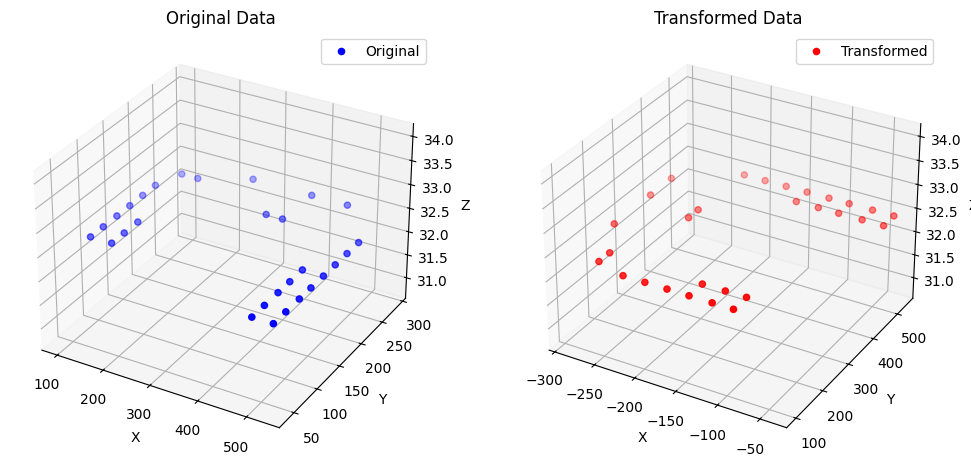

In [10]:
# Plotting the original and transformed points
fig = plt.figure(figsize=(12, 6))

# Original data plot
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(data['X'], data['Y'], data['Z'], color='b', label='Original')
ax1.set_title('Original Data')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.legend()

# Transformed data plot
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(transformed_data['X'], transformed_data['Y'], transformed_data['Z'], color='r', label='Transformed')
ax2.set_title('Transformed Data')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
ax2.legend()

plt.show()

In [11]:
for tx in scene.transmitters:
    scene.remove(tx)

In [12]:
transformed_data.to_csv('transformed_data.csv', index=False, header=False)

In [13]:
transmitters = load_transmitters("transformed_data.csv")

for name, position in transmitters:
    tx = Transmitter(name=name, position=position)
    scene.add(tx)

In [14]:
scene.preview()

Renderer(camera=PerspectiveCamera(aspect=1.31, children=(DirectionalLight(intensity=0.25, matrixWorldNeedsUpda…

# Simulate signal

In [15]:
scene.frequency = 2.4e9

In [17]:
# Remove existing receivers first
for rx_item in scene.receivers:
    scene.remove(rx_item)

# Configure antenna array for all transmitters
scene.tx_array = PlanarArray(num_rows=2,
                            num_cols=2,
                            vertical_spacing=0.5,    
                            horizontal_spacing=0.5,  
                            pattern="dipole",        
                            polarization="VH")

# Configure antenna array for all receivers
scene.rx_array = PlanarArray(num_rows=2,
                        num_cols=2,
                        vertical_spacing=0.5,
                        horizontal_spacing=0.5,
                        pattern="dipole",
                        polarization="VH")

# Place receiver INSIDE the building based on AP coordinate ranges
# APs are roughly at X: -286 to 140, Y: -317 to 222, Z: ~32
# rx = Receiver(name="rx",
#               position=[200, 35, -200],  # Center of building at floor level
#                orientation=[0, 0, 0])

#scene.add(rx)

In [18]:
#tx = Transmitter(name="test", position=[1, 1, 15], orientation=[0,0,0])
#scene.add(tx)
#tx.look_at(rx)
print("Using real AP transmitters instead of test transmitter")

Using real AP transmitters instead of test transmitter


In [19]:
print(scene.transmitters)
print(scene.receivers)

{'D1_2F_AP08': <sionna.rt.transmitter.Transmitter object at 0x72ee5a1deb50>, 'D1_2F_AP07': <sionna.rt.transmitter.Transmitter object at 0x72ee5a1ec610>, 'D1_2F_AP06': <sionna.rt.transmitter.Transmitter object at 0x72ee4ff6a850>, 'D1_2F_AP05': <sionna.rt.transmitter.Transmitter object at 0x72ee5ab66650>, 'D1_2F_AP04': <sionna.rt.transmitter.Transmitter object at 0x72ee5ab66b10>, 'D1_2F_AP03': <sionna.rt.transmitter.Transmitter object at 0x72ee5a198810>, 'D1_2F_AP09': <sionna.rt.transmitter.Transmitter object at 0x72ee5ab678d0>, 'D1_2F_AP10': <sionna.rt.transmitter.Transmitter object at 0x72ee5a1483d0>, 'D1_2F_AP11': <sionna.rt.transmitter.Transmitter object at 0x72ee5a1a5fd0>, 'D1_2F_AP02': <sionna.rt.transmitter.Transmitter object at 0x72ee5ab66bd0>, 'D1_2F_AP01': <sionna.rt.transmitter.Transmitter object at 0x72ee4ff89990>, 'D1_2F_AP27': <sionna.rt.transmitter.Transmitter object at 0x72ee5a168110>, 'D1_2F_AP28': <sionna.rt.transmitter.Transmitter object at 0x72ee4ff3bf10>, 'D1_2F_AP29

In [20]:
paths = scene.compute_paths()

ValueError: No receiver defined.

In [21]:
scene.preview(paths=paths) 

NameError: name 'paths' is not defined

In [22]:
cm = scene.coverage_map(cm_cell_size=[1.,1.], num_samples=int(1e5))

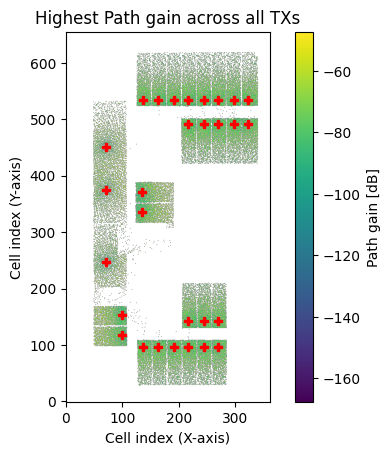

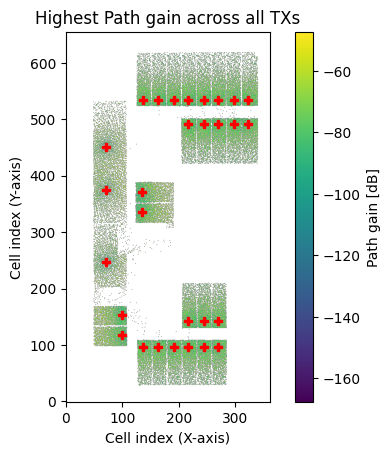

In [23]:
cm.show()